In [1]:
import xarray as xr 
import numpy as np
import regionmask
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


/opt/anaconda3/envs/basemap/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
o3 = xr.open_dataset('cmip6_data/u-be647_ann_mean_surface_level_o3.nc')#, chunks = {'time': 10})
o3 = o3.assign_coords(longitude=(((o3.longitude + 180) % 360) - 180)).sortby('longitude')
RMM_AIR = 28.97 # g mol-1
RMM_OZONE = 47.997 # g mol-1
MMR_to_PPBV = RMM_AIR/RMM_OZONE*1e9
o3.o3.values = o3.o3.values*MMR_to_PPBV

In [3]:
PATH_TO_SHAPEFILE = 'shapefiles/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'
world = gpd.read_file(PATH_TO_SHAPEFILE)

In [4]:
# create a mask of countries and apply it to O3 field
mask_poly = regionmask.Regions(name = 'world_mask', 
                               numbers = list(range(0,len(world.geometry.values))), 
                               names = list(world.ISO_A3), 
                               abbrevs=list(world.ISO_A3), 
                               outlines = list(world.geometry.values[i] for i in range(0,len(world.geometry.values))))
mask = mask_poly.mask(o3.isel(time = 0), lat_name='latitude', lon_name='longitude')

In [5]:
import warnings
feeling_cheeky = True
if feeling_cheeky:
    warnings.filterwarnings("ignore")

res = pd.DataFrame( columns=["Mean O3", "Abbrev"])
for ivar in range(0, len(world.geometry.values)):
    o3mean = float((o3.o3.isel(time = 0)).compute().where(mask==ivar).mean().values)
    tmp = pd.DataFrame([[o3mean, mask_poly.regions[ivar].abbrev]], columns=["Mean O3", "Abbrev"])#[o3.o3.compute().where(mask == region).mean().values
    res = res.append(tmp);


In [6]:
for_plotting = world.merge(res, left_on = 'ISO_A3', right_on = 'Abbrev')

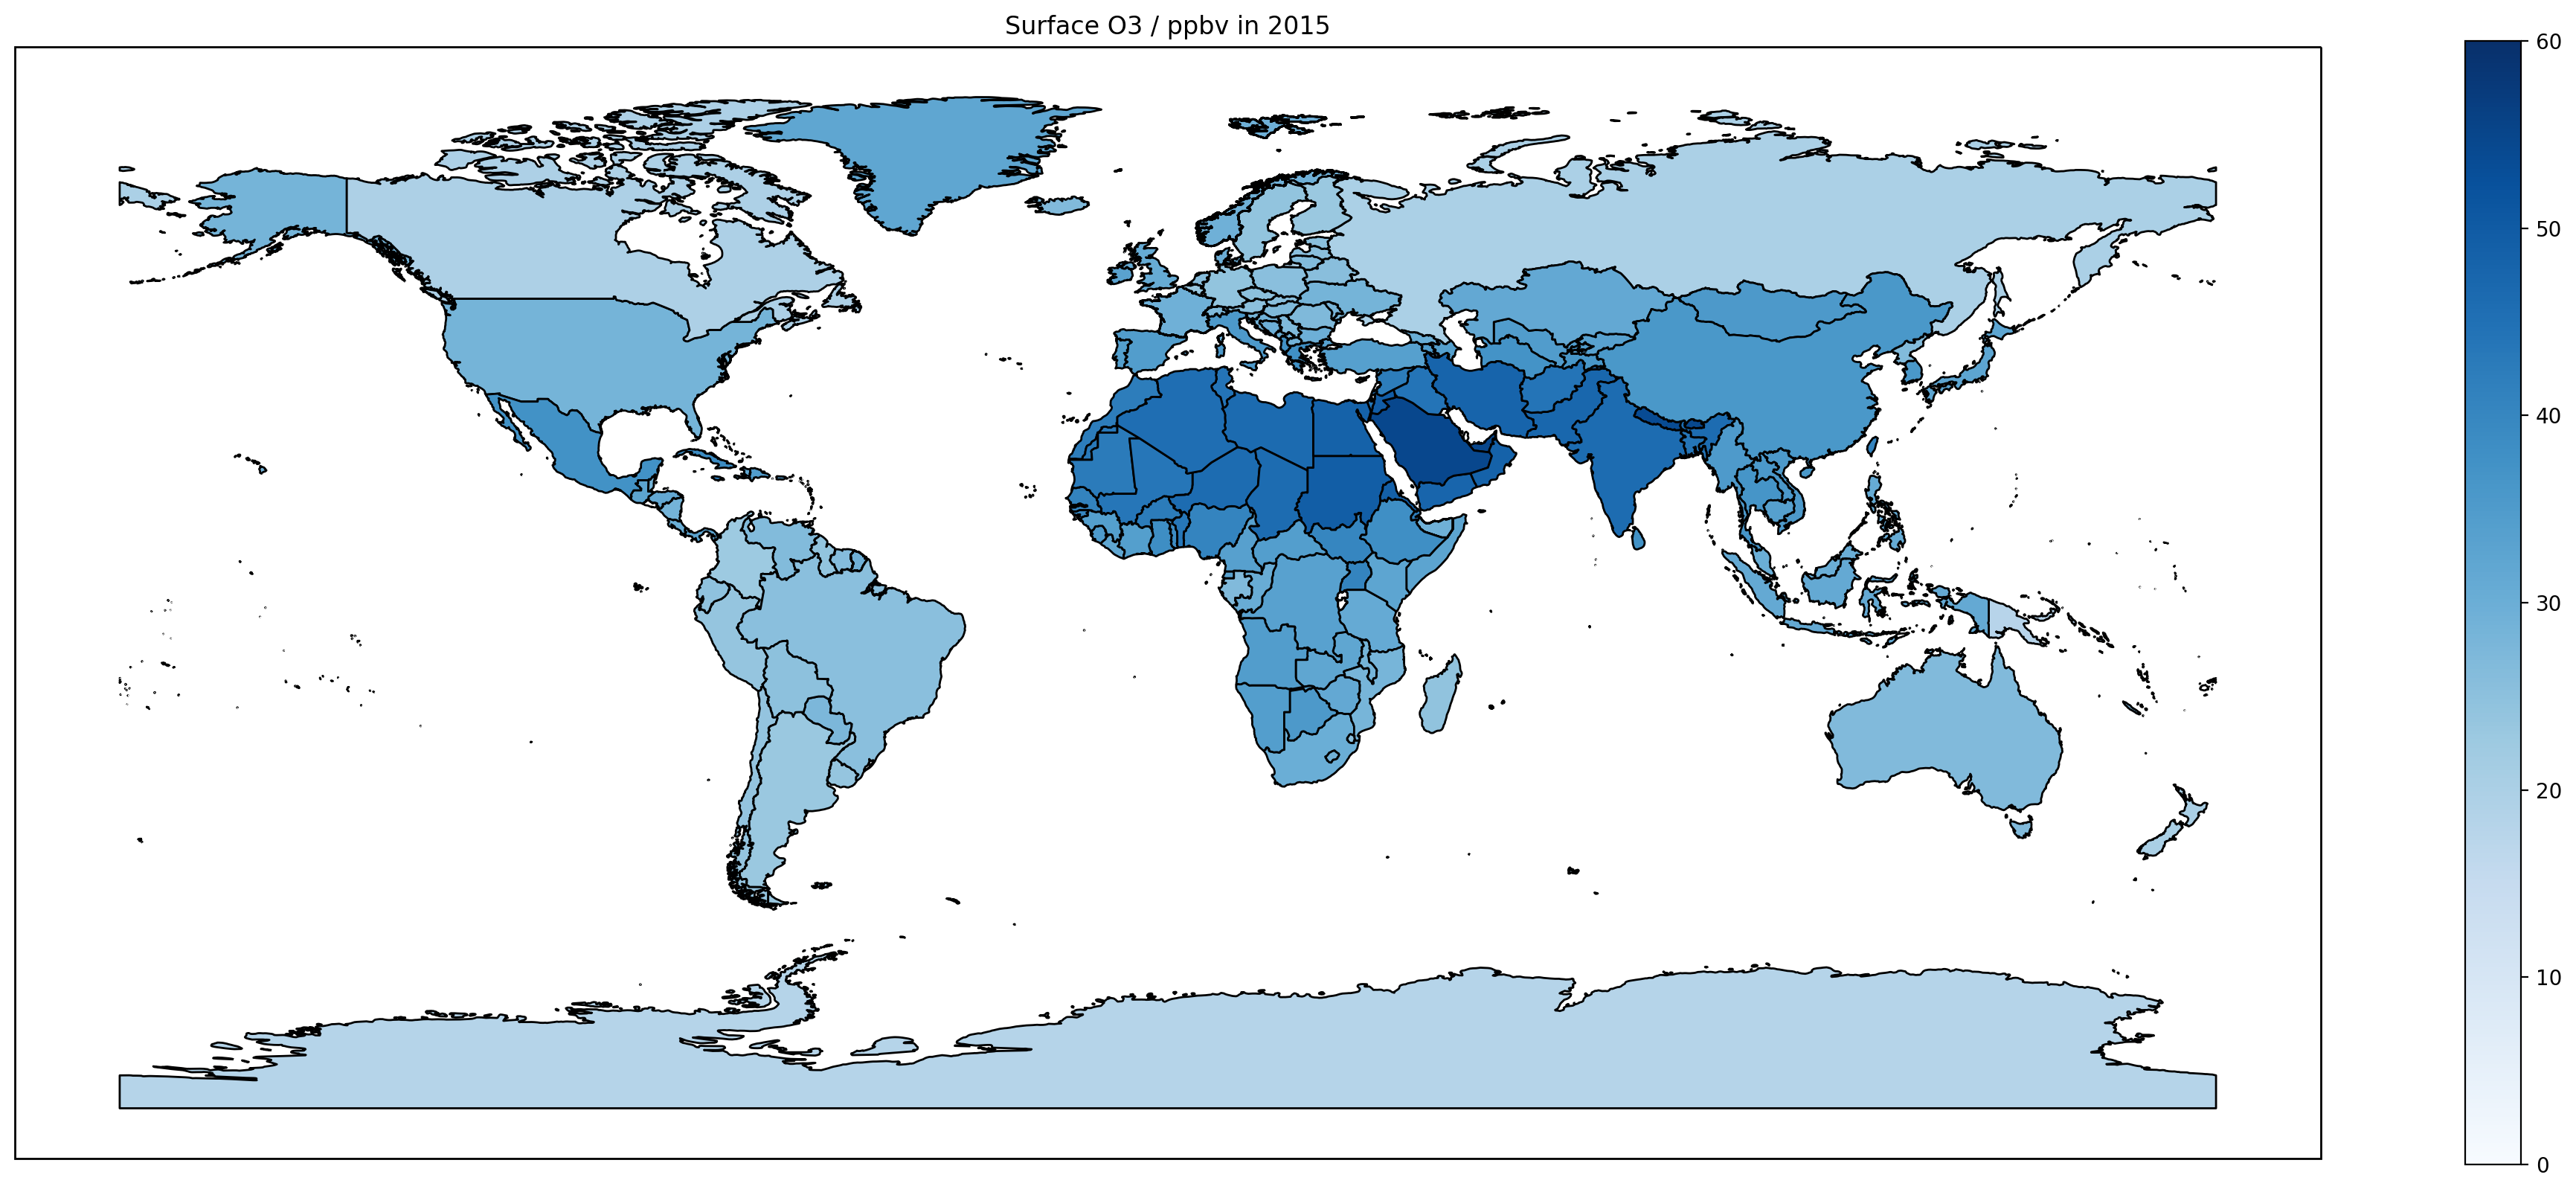

In [9]:
fig, ax = plt.subplots(figsize=(25, 10), dpi=200,  subplot_kw=dict(projection=ccrs.Robinson()))
for_plotting.plot(column='Mean O3',cmap ='Blues', edgecolor='k', vmin=0, vmax=60, 
         legend=True,ax=ax)
plt.title('Surface O3 / ppbv in 2015');

# Change in ozone 2100 vs 2015

In [13]:
diffres = pd.DataFrame( columns=["Mean O3", "Abbrev"])
for ivar in range(0, len(world.geometry.values)):
    o3mean = float((o3.o3.isel(time = -1)-o3.o3.isel(time = 0)).compute().where(mask==ivar).mean().values)
    tmp = pd.DataFrame([[o3mean, mask_poly.regions[ivar].abbrev]], columns=["Mean O3", "Abbrev"])#[o3.o3.compute().where(mask == region).mean().values
    diffres = diffres.append(tmp);


In [14]:
diff_for_plotting = world.merge(diffres, left_on = 'ISO_A3', right_on = 'Abbrev')
diff_for_plotting = diff_for_plotting[['geometry','Mean O3']]

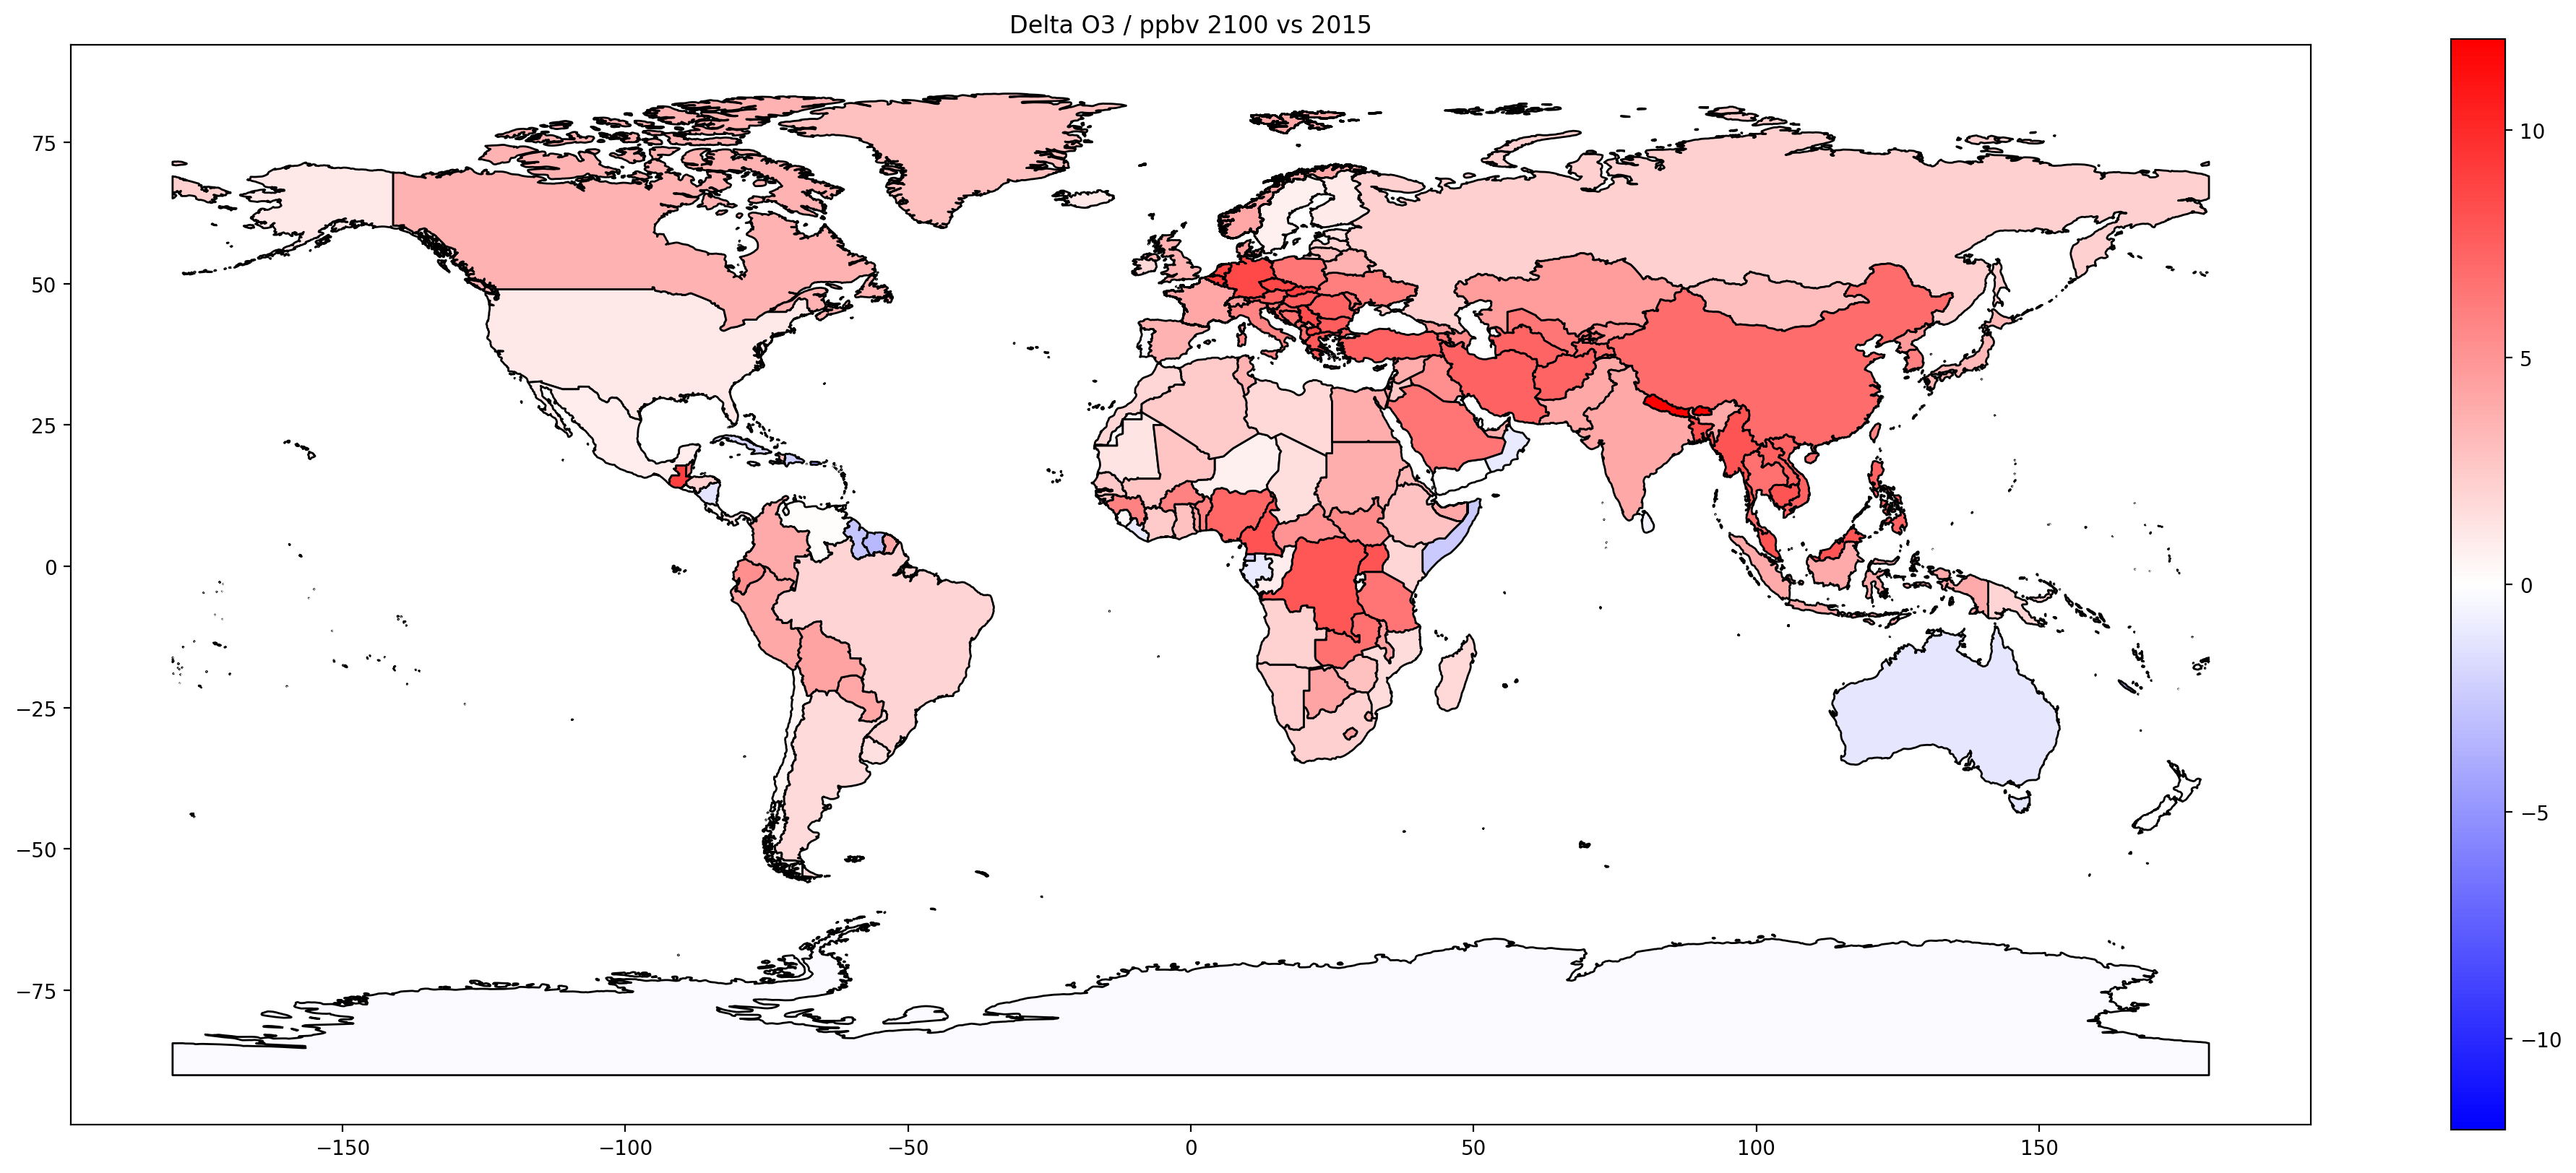

In [15]:
fig, ax = plt.subplots(figsize=(25, 10), dpi=200)
diff_for_plotting.plot(column='Mean O3',cmap ='bwr', edgecolor='k', vmin=-12, vmax=12, legend=True,ax=ax)
plt.title('Delta O3 / ppbv 2100 vs 2015');

## sanity check

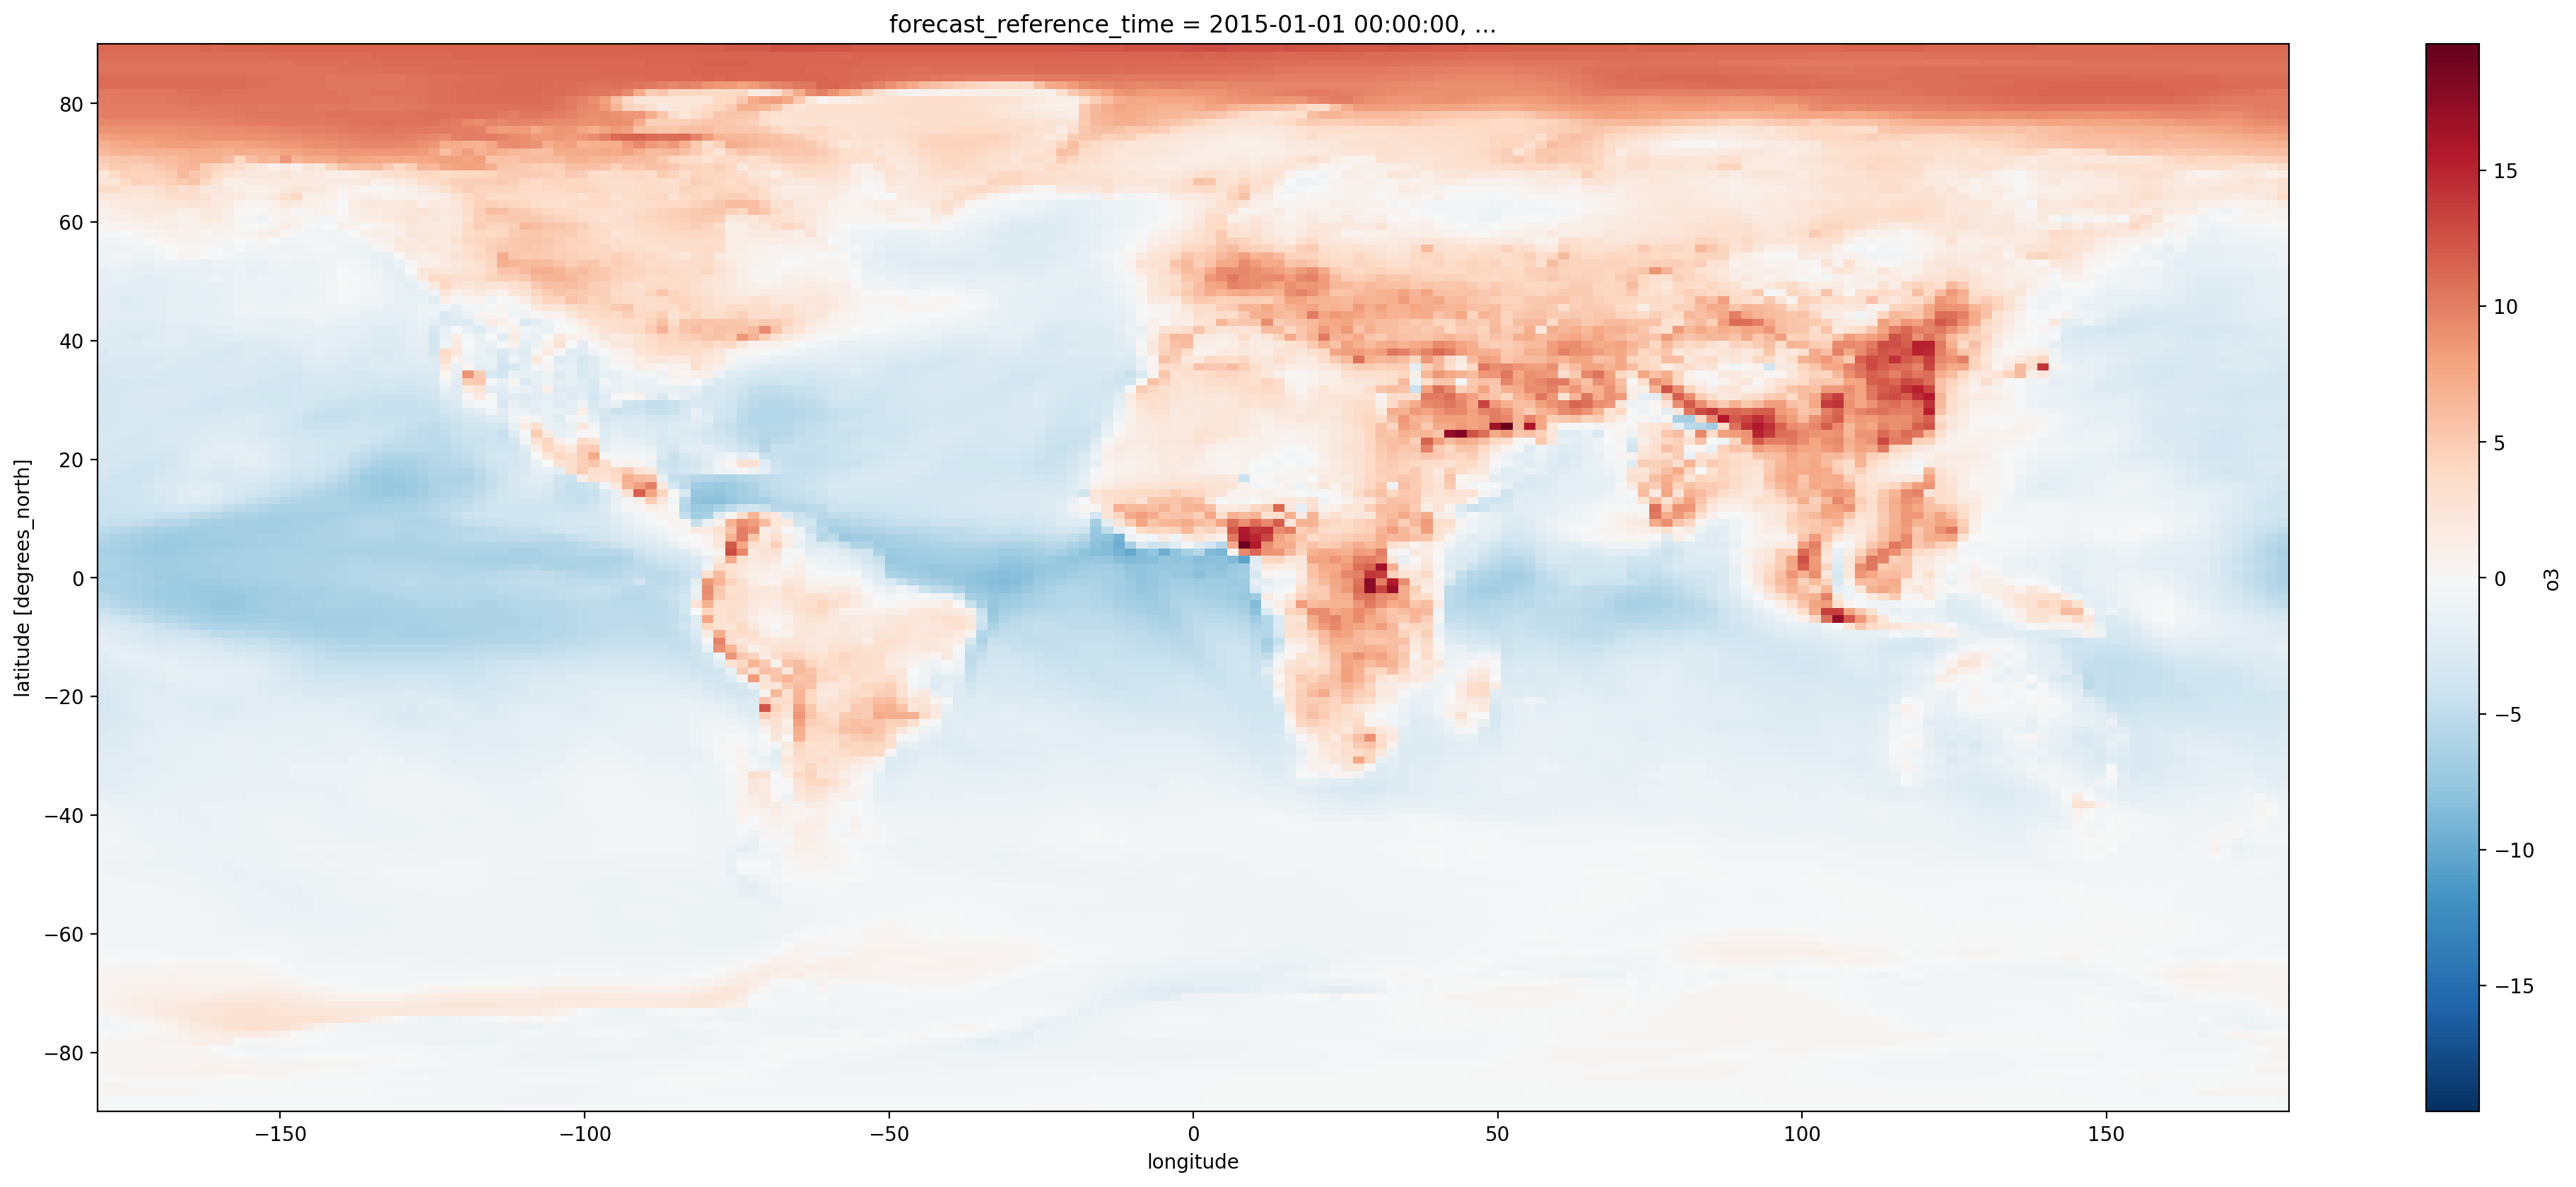

In [28]:
fig, ax = plt.subplots(figsize=(25, 10), dpi=200)
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
(o3.o3[-1,...]-o3.o3[0,...]).plot()

# Trend (not linear decline but who cares for now?)

In [16]:
nlats = len(o3.latitude.values)
nlons = len(o3.longitude.values)
trend = np.empty([nlats, nlons])
for ilat in range(0, nlats):
    for ilon in range(0, nlons):
        y = o3.o3[:,0,ilat, ilon]
        x = np.arange(2015,(2100))
        fit = np.polyfit(x, y, 1)
        trend[ilat, ilon] = fit[0]

In [17]:
o3['trend'] = xr.DataArray(data=trend, coords=[o3.latitude, o3.longitude], dims=["latitude", "longitude"])

In [18]:
trendres = pd.DataFrame( columns=["Mean O3", "Abbrev"])
for ivar in range(0, len(world.geometry.values)):
    o3mean = float(o3.trend.compute().where(mask==ivar).mean().values)
    tmp = pd.DataFrame([[o3mean, mask_poly.regions[ivar].abbrev]], columns=["Mean O3", "Abbrev"])#[o3.o3.compute().where(mask == region).mean().values
    trendres = trendres.append(tmp);

In [19]:
for_plotting = world.merge(trendres, left_on = 'ISO_A3', right_on = 'Abbrev')
for_plotting = for_plotting[['geometry','Mean O3']]

Text(0.5, 1.0, 'Trend Surface O3 / ppbv per year as linear trend')

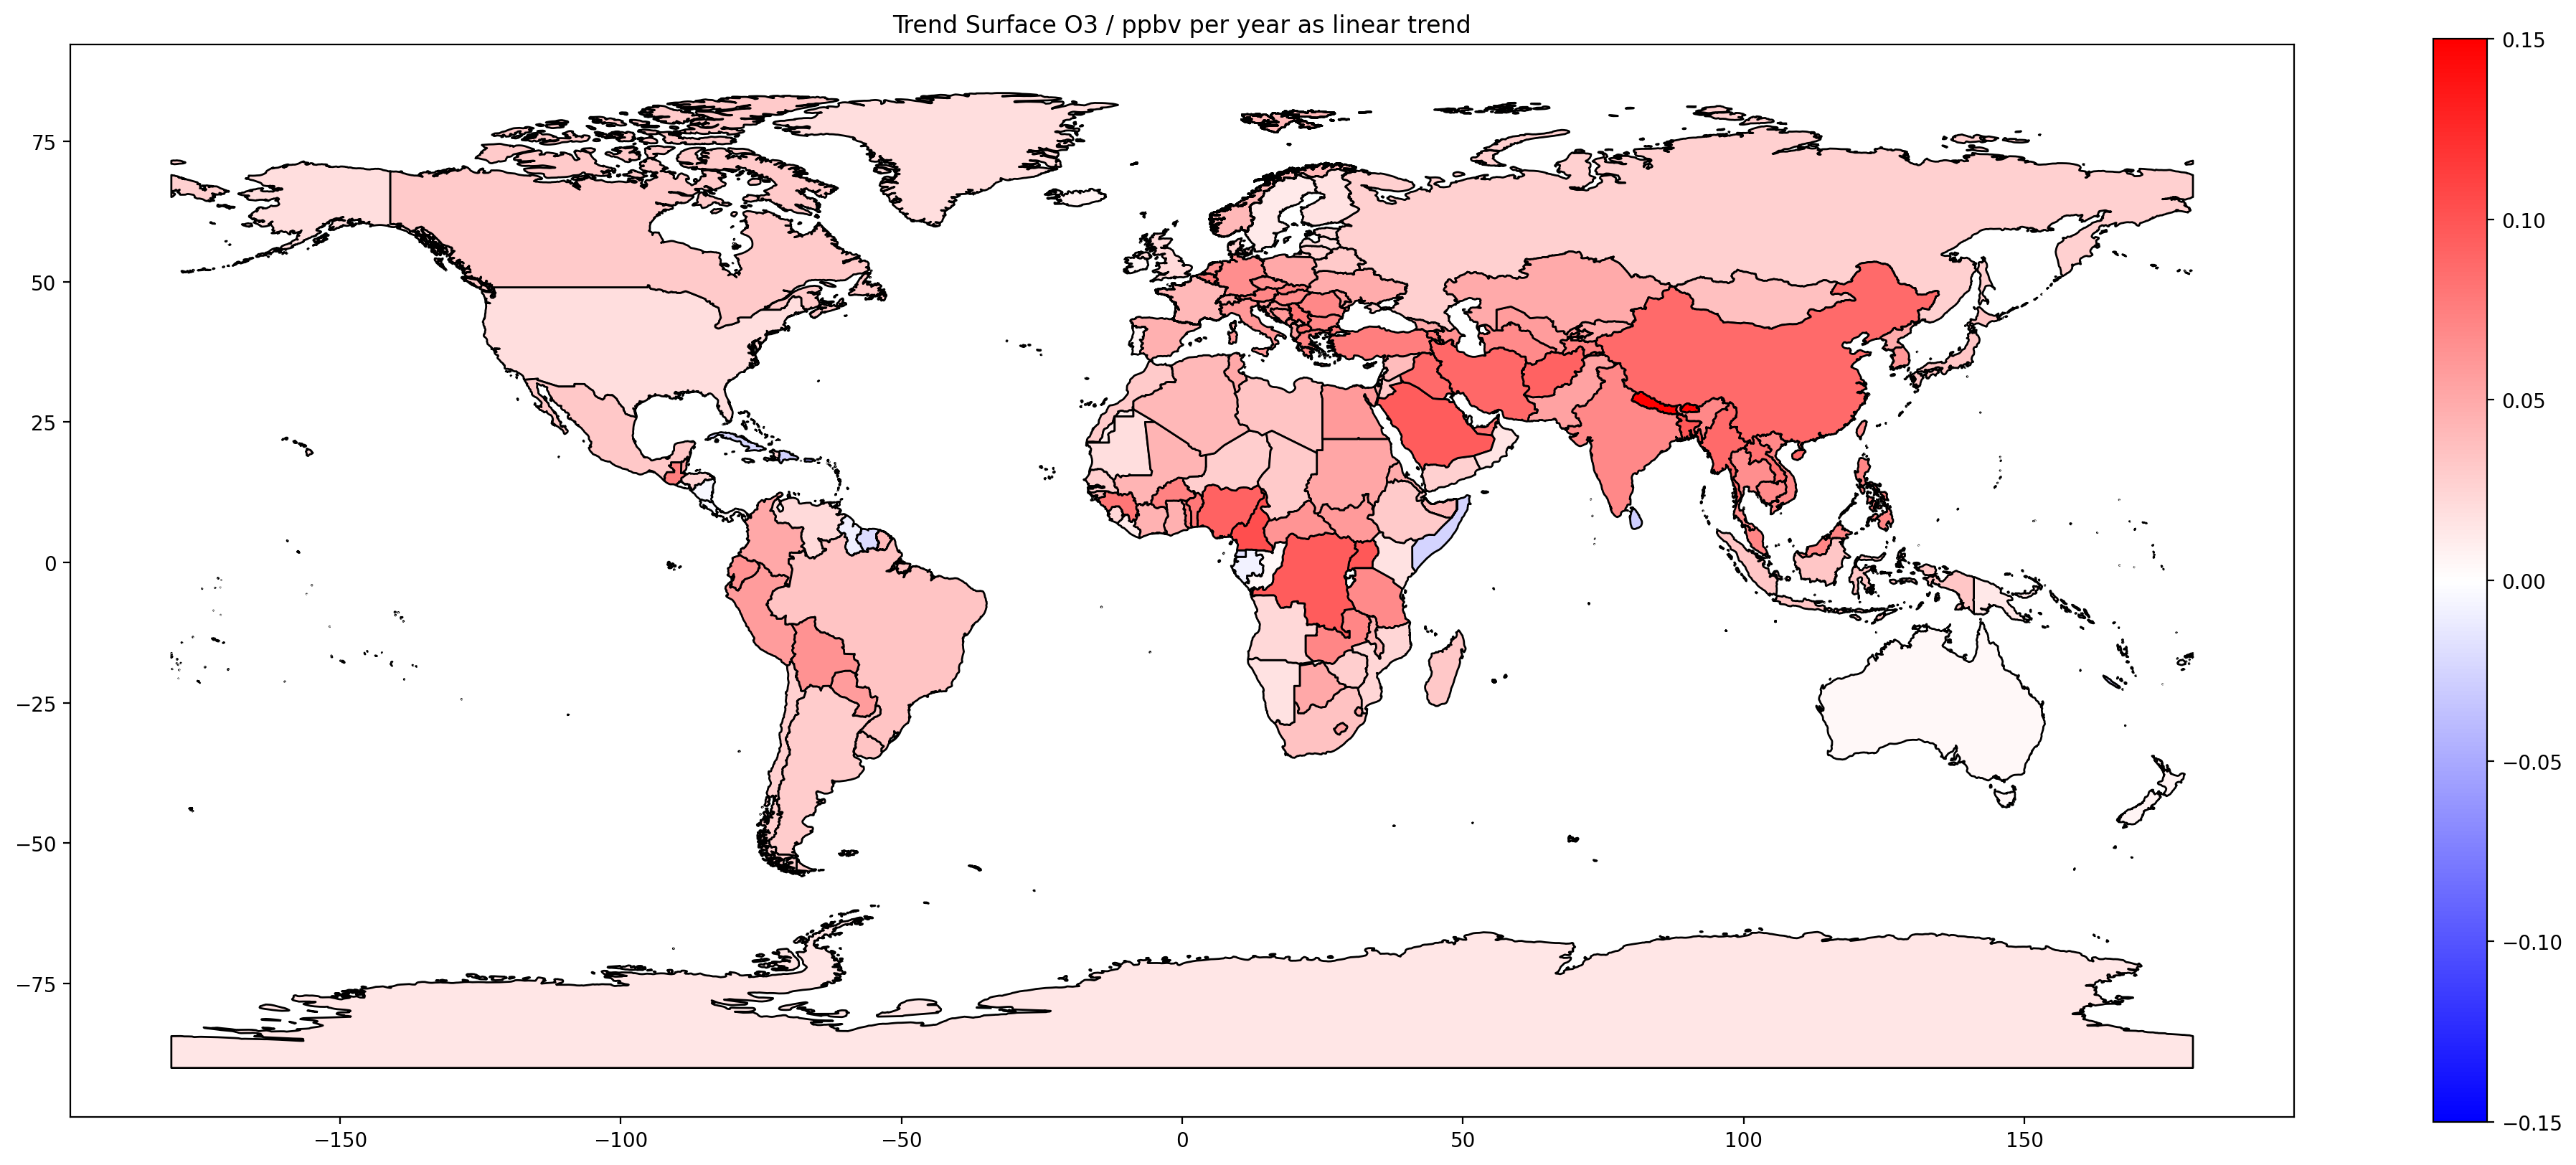

In [20]:
# add grey to a colormap to represent missing value
fig, ax = plt.subplots(figsize=(25, 10), dpi=200)
for_plotting.plot(column='Mean O3',cmap ='bwr', edgecolor='k', legend=True,ax=ax, vmin=-0.15, vmax=0.15)
plt.title('Trend Surface O3 / ppbv per year as linear trend')